# AMV Historical Data

In [1]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [2]:
# 2. Read data
data = pd.read_csv('AMV Historical Data.csv')

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)
data = data.replace(',', '', regex=True)

# Preprocessing data
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

data["Vol."] = data["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

data["Change %"] = data["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str):
    return float(str.replace(',', ''))

data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

df1 = data.reset_index()['Price']

In [3]:
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,15225.0,15270.0,15315.0,15180.0,4700,-0.0029
2019-03-04,14865.0,15180.0,15180.0,14865.0,19010,-0.0236
2019-03-05,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
2019-03-06,14594.0,14414.0,14684.0,14414.0,17250,0.0125
2019-03-07,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
...,...,...,...,...,...,...
2024-05-27,3500.0,3500.0,3600.0,3500.0,660470,0.0000
2024-05-28,3500.0,3500.0,3600.0,3500.0,452540,0.0000
2024-05-29,3500.0,3500.0,3600.0,3500.0,522679,0.0000


In [4]:
df1

0       15225.0
1       14865.0
2       14414.0
3       14594.0
4       14144.0
         ...   
1308     3500.0
1309     3500.0
1310     3500.0
1311     3600.0
1312     3700.0
Name: Price, Length: 1313, dtype: float64

In [5]:
# 3. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [6]:
# 4. Split train, test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 7. Define LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 8. Fit the model with train data

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.2050 - val_loss: 0.0136
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0230 - val_loss: 0.0265
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0134 - val_loss: 0.0077
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0087 - val_loss: 0.0020
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0074 - val_loss: 3.2969e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0055 - val_loss: 1.4861e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0062 - val_loss: 2.4425e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051 - val_loss: 2.5495e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0053 - val_loss: 3.7541e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0048 - val_loss: 2.1844e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0045 - val_loss: 3.2628e-04
Epoch 12/100
14/14 ━━━━━

In [11]:
# 9. Predict test data
y_pred = model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [12]:
# 10. Valuation
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape, '%')
print('MSLE:', test_score_msle)

RMSE: 162.54965882111307
MAPE: 3.000536946755092 %
MSLE: 0.0016135518692379665


In [13]:
# 11. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [14]:
# 12. Predict next 30 days, 60 days, 90 days

lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))

lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))

lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

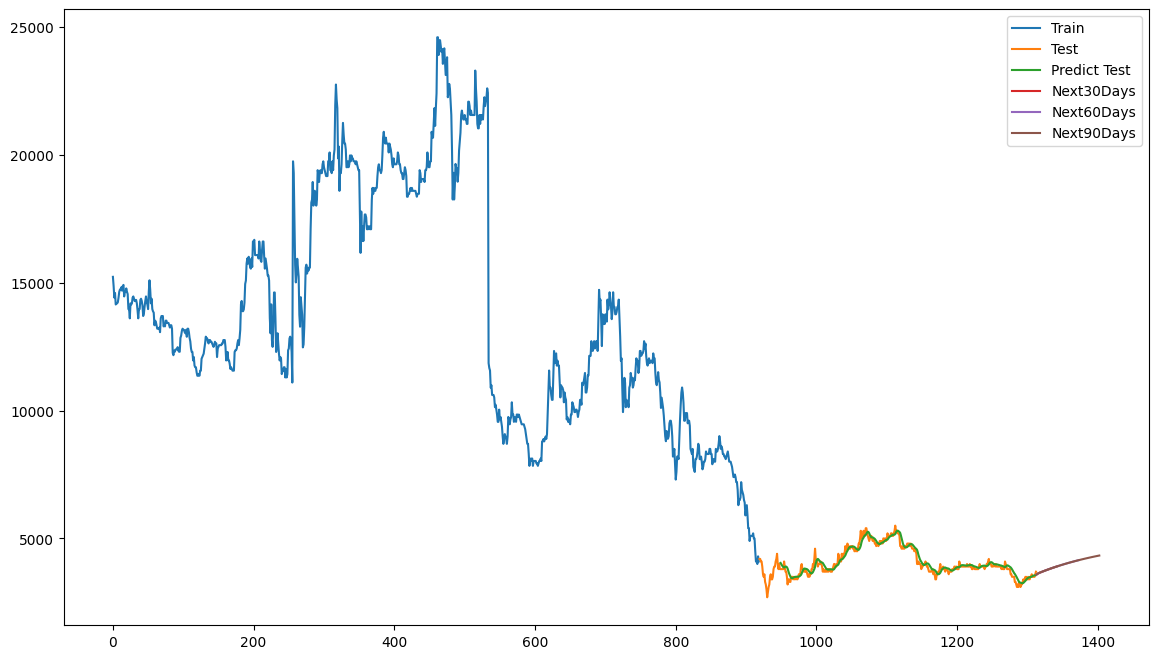

In [15]:
# 13. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predict Test')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()

# DHT Historical Data

In [16]:
# 2. Read data
data = pd.read_csv('DHT Historical Data.csv')

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)
data = data.replace(',', '', regex=True)

# Preprocessing data
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

data["Vol."] = data["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

data["Change %"] = data["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str):
    return float(str.replace(',', ''))

data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

df1 = data.reset_index()['Price']

In [17]:
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,10860.1,10916.2,11224.9,10663.6,138720,0.0184
2019-03-04,11224.9,11056.5,11477.4,11056.5,296000,0.0336
2019-03-05,11337.1,11224.9,11365.2,10888.1,308000,0.0100
2019-03-06,11561.6,11309.1,11589.7,11309.1,292910,0.0198
2019-03-07,11589.7,11842.2,11842.2,11224.9,240150,0.0024
...,...,...,...,...,...,...
2024-05-27,38600.0,35200.0,39900.0,35200.0,133260,0.0604
2024-05-28,39300.0,38600.0,39500.0,38200.0,61630,0.0181
2024-05-29,39500.0,39900.0,39900.0,38300.0,107350,0.0051


In [18]:
df1

0       10860.1
1       11224.9
2       11337.1
3       11561.6
4       11589.7
         ...   
1307    38600.0
1308    39300.0
1309    39500.0
1310    39300.0
1311    40400.0
Name: Price, Length: 1312, dtype: float64

In [19]:
# 3. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [20]:
# 4. Split train, test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [21]:
# 5. Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [22]:
# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
# 7. Define LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# 8. Fit the model with train data

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0184 - val_loss: 0.0460
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0024 - val_loss: 0.0218
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0012 - val_loss: 0.0100
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.1903e-04 - val_loss: 0.0055
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.3520e-04 - val_loss: 0.0059
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.9927e-04 - val_loss: 0.0065
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.8212e-04 - val_loss: 0.0061
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.8651e-04 - val_loss: 0.0048
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.3507e-04 - val_loss: 0.0075
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.7579e-04 - val_loss: 0.0052
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0098e-04 - val_loss: 0.0057
Epoch 12/100
14/14 ━

In [25]:
# 9. Predict test data
y_pred = model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [26]:
# 10. Valuation
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape, '%')
print('MSLE:', test_score_msle)

RMSE: 1298.349674946451
MAPE: 3.20366914899499 %
MSLE: 0.002255299250582985


In [27]:
# 11. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [28]:
# 12. Predict next 30 days, 60 days, 90 days

lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))

lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))

lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

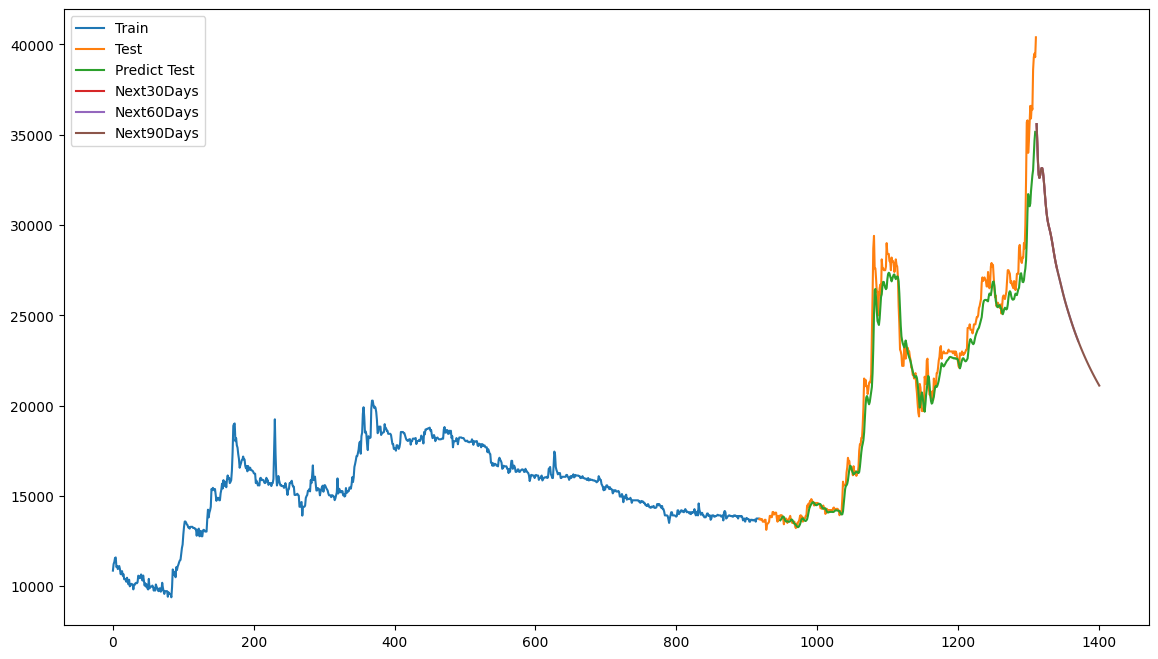

In [29]:
# 13. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predict Test')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()

# DP3 Historical Data

In [30]:
# Read data
data = pd.read_csv('DP3 Historical Data.csv')

data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)
data = data.replace(',', '', regex=True)

# Preprocessing data
def convert_volume_to_number(volume):
    if isinstance(volume, str):
        if volume[-1] == 'K':
            return int(float(volume[:-1]) * 1000)
        elif volume[-1] == 'M':
            return int(float(volume[:-1]) * 1000000)
        elif volume[-1] == 'B':
            return int(float(volume[:-1]) * 1000000000)
        else:
            return int(volume)
    else:
        return volume

data["Vol."] = data["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

data["Change %"] = data["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str_value):
    return float(str_value.replace(',', ''))

data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

df1 = data.reset_index()['Price']

In [31]:
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,73800.0,73000.0,73900.0,73000.0,1540.0,0.0054
2019-03-04,74900.0,73800.0,75200.0,73800.0,8340.0,0.0149
2019-03-05,74400.0,75000.0,75000.0,74000.0,7330.0,-0.0067
2019-03-06,74700.0,74100.0,75000.0,74000.0,3810.0,0.0040
2019-03-07,76300.0,75000.0,76900.0,74700.0,11570.0,0.0214
...,...,...,...,...,...,...
2024-05-27,60900.0,61700.0,61700.0,60900.0,12670.0,-0.0016
2024-05-28,61000.0,61000.0,61800.0,60900.0,7900.0,0.0016
2024-05-29,61000.0,62000.0,62000.0,61000.0,7300.0,0.0000


In [32]:
df1

0       73800.0
1       74900.0
2       74400.0
3       74700.0
4       76300.0
         ...   
1132    60900.0
1133    61000.0
1134    61000.0
1135    61500.0
1136    61600.0
Name: Price, Length: 1137, dtype: float64

In [33]:
# 3. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [34]:
# 4. Split train, test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [35]:
# 5. Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [36]:
# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [37]:
# 7. Define LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# 8. Fit the model with train data

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1561 - val_loss: 0.0046
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0184 - val_loss: 0.0091
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0100 - val_loss: 0.0012
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0066 - val_loss: 0.0013
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0060 - val_loss: 9.9321e-04
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0047 - val_loss: 8.6346e-04
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [39]:
# 9. Predict test data
y_pred = model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [40]:
# 10. Valuation
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape, '%')
print('MSLE:', test_score_msle)

RMSE: 2381.675649315704
MAPE: 2.9522757935173614 %
MSLE: 0.0017976269565756545


In [41]:
# 11. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [42]:
# 12. Predict next 30 days, 60 days, 90 days

lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))

lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))

lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

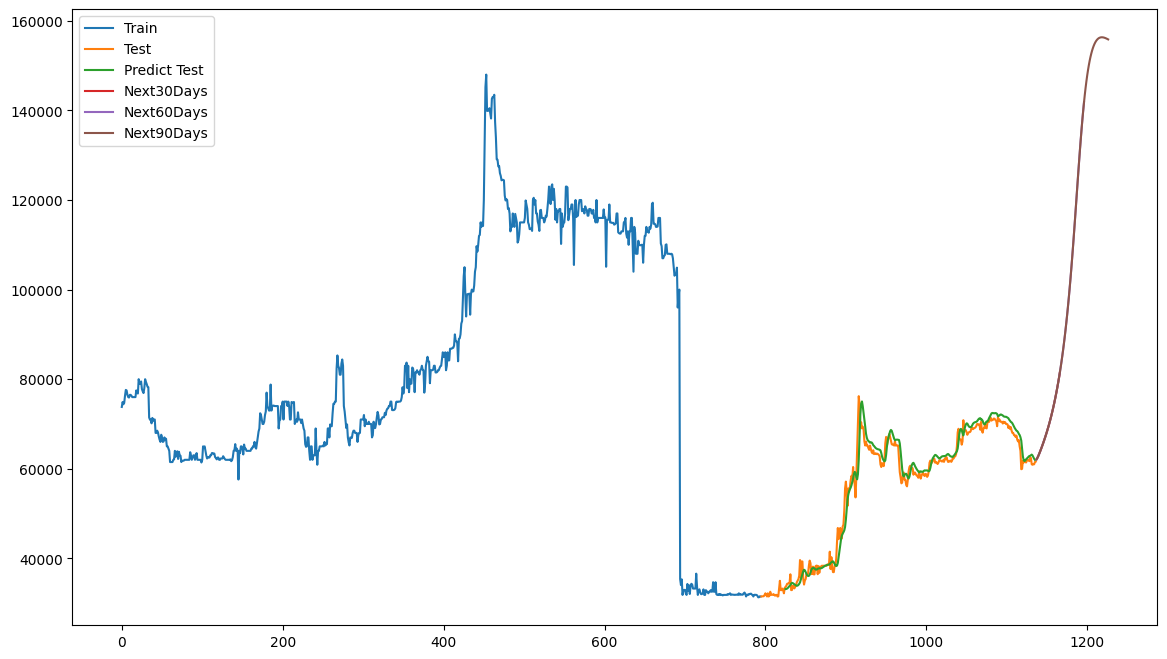

In [43]:
# 13. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predict Test')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()